---
title: Perceptron Blog Post
author: Otis Milliken
date: '2024-04-02'
description: "Blog Post for the Fourth Assignment in CS0451"
format: html
---

# Abstract

In this blog post, I examine a way to find a line that separates two sets of data using the perceptron algorithm. I will see how this perceptron algorithm works well in two dimensions but also on n-dimensional data. I will also examine the limitations of this algorithm on non-linear seperable data. Lastly, I'll examine a variant of the perceptron algorithm called the mini-batch perceptron algorithm.

## Loading in Perceptron Implementation

In [16]:
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Perceptron Link
https://github.com/Hokalaka2/Hokalaka2.github.io/blob/main/posts/perceptron.py

## Walk-Through of How Perceptron.grad

In this blog post we had to figure out implement the Perceptron.grad() function which calculates our gradient which we use in our step function. This function involves:
1. Calculating the scores
2. Returning the vector 1[s<sub>i</sub> y<sub>i</sub> < 0]y<sub>i</sub> X<sub>i</sub>

In python this translate to my function grad which is defined as: 

function grad(self.X): \
    s = self.score(X) \
    mult = y.T * s \
    matrix = torch.where(mult < 0, y, 0.0) \
    return matrix @ X 

Basically if mult is smaller than 0 then we put in y<sub>i</sub> so that when we multiply the whole matrix by X, we get y<sub>i</sub>X<sub>i</sub> for all points that are smaller than 0. 

## Perceptron Data

This is where I implemented how I get perceptron data. This code was partially taken from our lectures and warm up. It basically adds randomness to the points and makes the points linear seperable. It also makes the targets -1 and 1 instead of 0, and 1 because it makes it easier to change the color of the points. 
We also add a method that allows us to plot our 2 dimensional points.

Lastly we plot the points to show what the points distribution looks like.

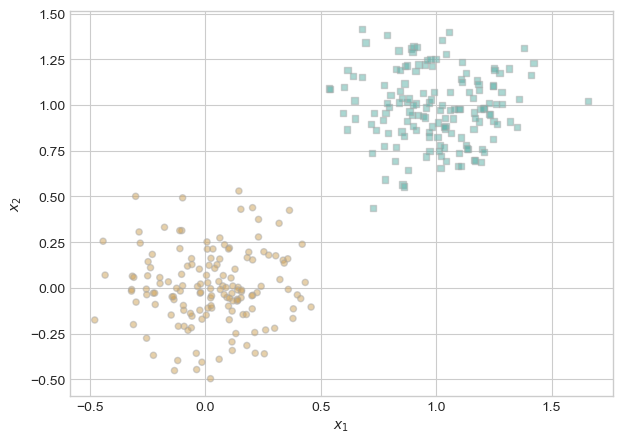

In [17]:
import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

torch.manual_seed(123456)

def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    y = 2*y - 1
    y = y.type(torch.FloatTensor)

    return X, y

def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [-1, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = perceptron_data()
plot_perceptron_data(X, y, ax)

## Examining the data
I select fifty of these points in order to use for my model because it felt somewhat uneccesarry to use all the points for this simple example. As we can see, the points are clearly linearly seperable.

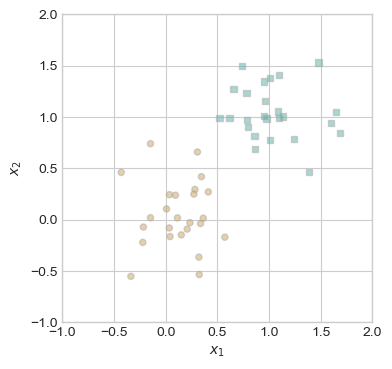

In [18]:
torch.manual_seed(123456)
X, y = perceptron_data(n_points = 50, noise = 0.3)
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)

## Draw line Function
I make a draw line function that allows us to vizualize the linear line that the model sets. This allows us to see progression and makes the Perceptron more intuitive.

In [19]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(*rgb)

## Perceptron Loop


In [20]:
from matplotlib.lines import Line2D
def perceptron_loop(X, y, max_iter = 1000, k = 1, alpha = 1.0, plot = False, plot_type = "color"):
    p = Perceptron() 
    opt = PerceptronOptimizer(p, alpha)
    
    p.loss(X, y)

    loss = 1.0
    
    if plot and plot_type == "color":
        fig, ax = plt.subplots(1, 1, figsize = (8, 6))
        rgb = (255, 0, 0)
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
    if plot and plot_type == "adjacent":
        plt.rcParams["figure.figsize"] = (7, 5)
        fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
        markers = ["o", ","]
        marker_map = {-1 : 0, 1 : 1}
        current_ax = 0

    # for keeping track of loss values
    loss_vec = []

    lines = []
    iter = 0
    loss_w = []
    while loss > 0 and iter < max_iter:
        old_w = torch.clone(p.w)
        i = torch.randperm(X.size(0))[:k]
        x_i = X[i,:]
        y_i = y[i]
        local_loss = opt.step(x_i, y_i, k) 
        if local_loss > 0:
            loss = p.loss(X, y) 
            loss_vec.append(loss)
            loss_w.append(torch.clone(p.w))
            if plot and plot_type == "adjacent" and current_ax < 6:
                ax = axarr.ravel()[current_ax]
                plot_perceptron_data(X, y, ax)
                draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
                draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
                ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[y[i].item()]])
                ax.set_title(f"loss = {loss:.3f}")
                ax.set(xlim = (-1, 2), ylim = (-1, 2))
                current_ax += 1
        iter += 1
    if plot and plot_type == "color":
        plot_perceptron_data(X, y, ax)
        for i in range(len(loss_vec)):
            draw_line(loss_w[i], x_min = -1, x_max = 2, ax = ax, color = rgb_to_hex(rgb), linestyle = "solid")
            lines.append(Line2D([0], [0], color=rgb_to_hex(rgb), lw=2, label="Line " + str(len(lines) + 1), linestyle='-'))
            red, green, blue = rgb
            rgb = (red-int(280/len(loss_vec)), 0, 0)
        ax.legend(handles = lines, loc="upper right")
    return loss_vec


## Color Representation

I wanted to make my own unique way to visualize the perceptron process so I made this fun color graph. The lines get darker as the model gets closer to convering. While it arguably works less successfully than the adjacent graph, it offers a new way to examine the process.

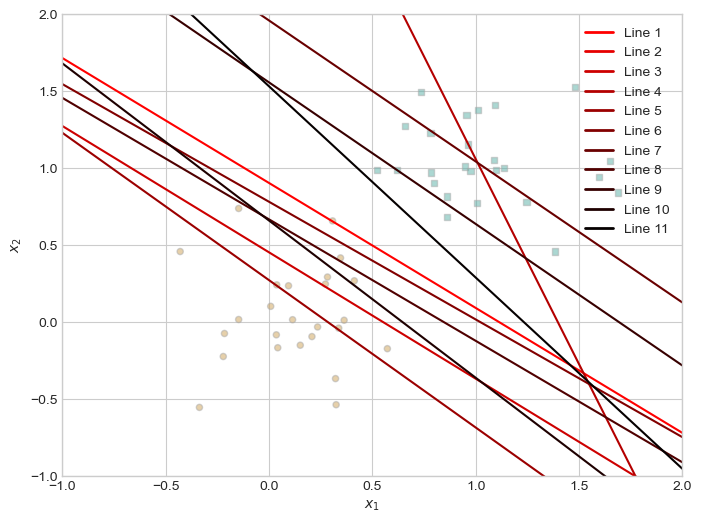

In [21]:
torch.manual_seed(123456)
loss_vec = perceptron_loop(X, y, plot = True, plot_type = "color")

Here is the algorithm loop but with adjacent graphs instead of different colored lines. This is more similar to what Prof. Phil did in class.

In [22]:
torch.manual_seed(123456)
loss_vec = perceptron_loop(X, y, k = 1, plot = False, plot_type = "adjacent")

## Convergence 

Here we can see the model converge to zero loss. In order to clear up the graph, this graph only shows the changes in p.w's and not every attempt.

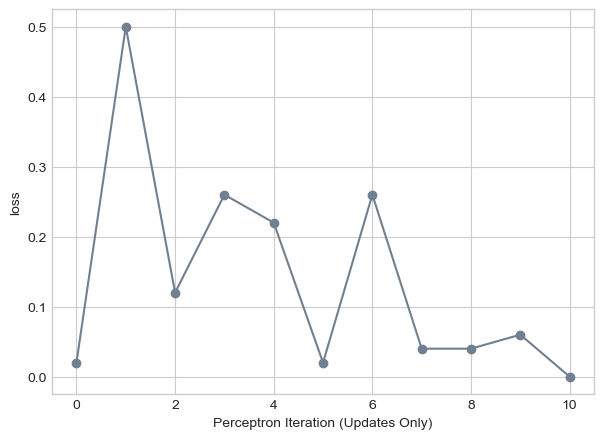

In [23]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

## Not Linearly Seperable Data
What if our data is not linearly seperable. In this next part, I make a completely random dataset. As we'll see, it would be impossible to drawn a line in order to make a loss of 0.

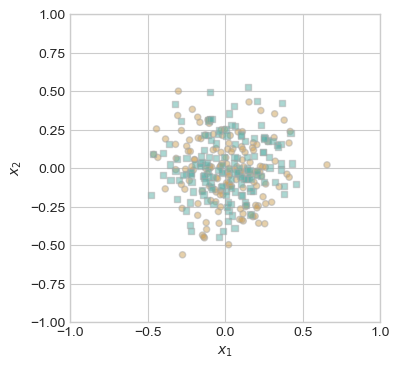

In [24]:
torch.manual_seed(123456)

def random_data(n_points = 300, noise = 0.2, p_dims = 2):
    X = torch.normal(0.0, noise, size = (n_points, p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    y = torch.rand(X.shape[0])
    y = 1 * (y > 0.5)
    y = 2 * y - 1
    y = y.type(torch.FloatTensor)
    return X, y

def plot_random_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [-1, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

X_rand, y_rand = random_data()
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 1), ylim = (-1, 1))
plot_random_data(X_rand, y_rand, ax)

So how does our perceptron algorithm fair in this instance. We'll as we can see in this next part, perceptron still tries to find a solution. It will jump around, trying new values but will never find a line that fits. This will continue forever. However, in my case, I have set a max number of iterations at 1000 so that it will stop then.

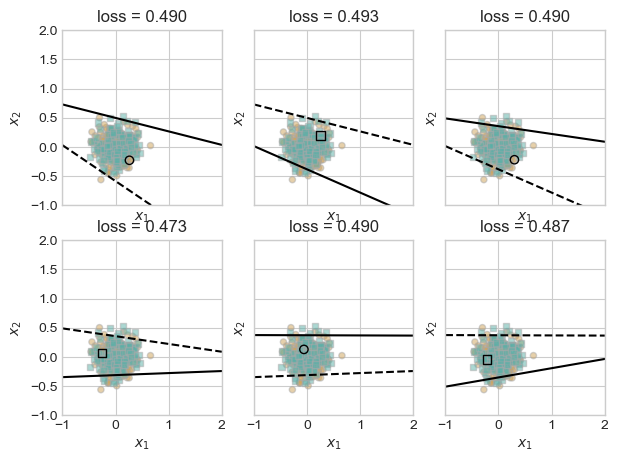

In [25]:
torch.manual_seed(123456)

loss_vec = perceptron_loop(X_rand, y_rand, plot = True, plot_type = "adjacent")


As we can see, it continues to jump around but without any solution. In this example, our perceptron tries a little over 500 different lines.

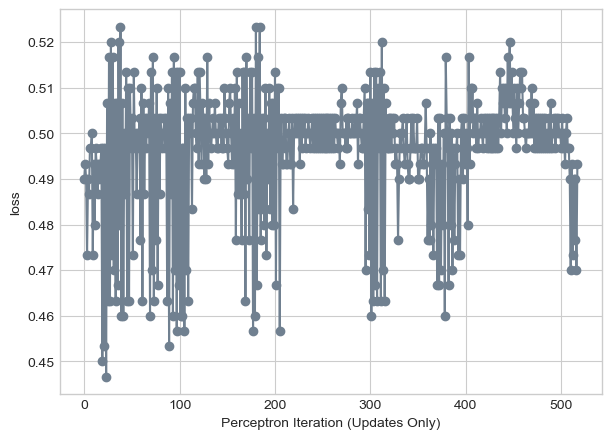

In [26]:

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")


## Multiple Dimensions

Very often data is not just 2 dimension. How does Perceptron work on 3, 4, 5 dimensional data sets. Well luckily, we can try this out! Our data method from the beginning allows us to change the number of dimensions of the dataset. 

In [27]:
torch.manual_seed(123456)

X_multiple, y_multiple = perceptron_data(n_points = 300, noise = 0.2, p_dims = 5)

## Result

As we can in the next graph, our algorithm still gets to zero loss! As long as our data is linearly seperable than perceptron algorithm will work.

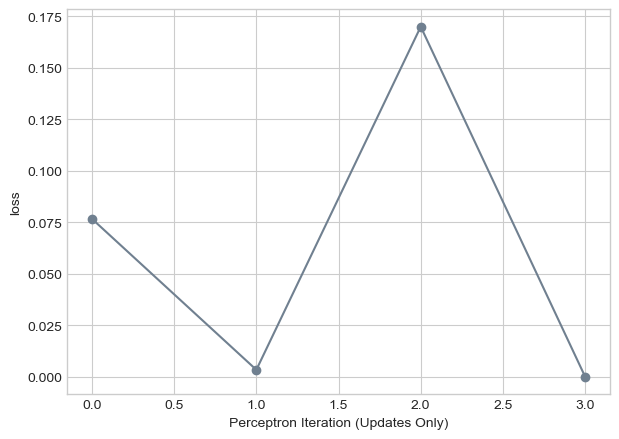

In [28]:
loss_vec = perceptron_loop(X_multiple, y_multiple, plot = False)

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

# Mini Batch Perceptron

There seems to be an obvious way to speed up our algorithm. What if instead of picking one random point and choosing a line, we pick a bunch of points together? This simple idea is behind the mini batch perceptron algorithm. We can choose k points and basically average our results of them. It also introduces the idea of alpha or a way to control the convergence of our algorithm. Too big of an alpha and we may overshoot our local minimum but too small of an alpha and convergence might take longer.

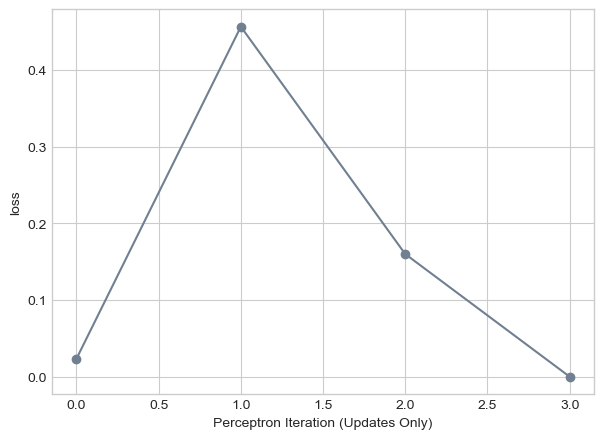

In [29]:
torch.manual_seed(1234)

loss_vec = perceptron_loop(X_multiple, y_multiple, k = 1, alpha = 1, plot = False)

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

## k = 10
Here we see our algorithm if we were to pick of k of 10. While we similar convergence times, it does less jumping around and has more of a constant decrease in loss. 

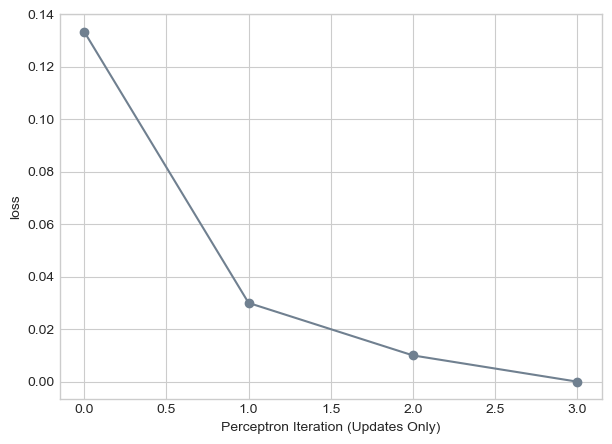

In [43]:
torch.manual_seed(1234)

loss_vec = perceptron_loop(X_multiple, y_multiple, k = 10, alpha = 1, plot = False)

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

## k = n

What if k = n. Well in this scenerio, since we're getting all of the points at once, alpha is the only thing changing our w. This means we'll converge even on data that is not linearly seperable. Here we see that.

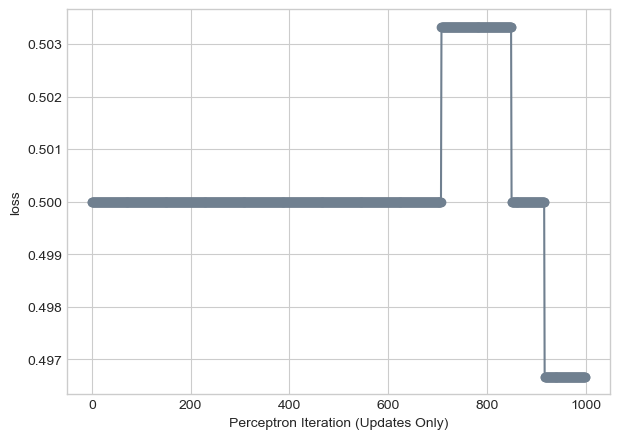

In [ ]:
torch.manual_seed(123456)

loss_vec = perceptron_loop(X_rand, y_rand, max_iter = 1000, k = X_rand.size()[0], alpha = 0.0001, plot = False)

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

## Runtime Considerations

A single iterations of the perceptrong algorithm picks a point and calculates the loss of that point. To calculate the loss, we need to go through every point and see if it's categorized correctly. This indicates that one iterations has a time complexity of O(n). Additionally if points have multiple features then this comparison increases to O(np) where p equals the number of features that we have.
A mini-batch iterations takes slightly longer since we're essentially doing multiple perceptron runs at one time. This increases the time complexity to O(knp) where k is the size of our batch. If our batch equals n, then the time complexity is O(pn^2)

# Discussion

In this blog post, we saw how the perceptron algorithm works effectively for linearly seperable data with any dimensionality. However, we also saw how the algorithm will continue for ever if the data isn't linearly seperable. Addionally, since the points chosen are random, the algorithm can occasionally take long to converge and it's difficult to know if the algorithm will ever converge (might take several iterations of the algorithm).